In [1]:
import bayesflow.diagnostics as diag
from bayesflow.amortizers import AmortizedPosterior
from bayesflow.networks import InvertibleNetwork, SequenceNetwork
from bayesflow.simulation import GenerativeModel, Prior, Simulator
from bayesflow.trainers import Trainer

import numpy as np
import pickle
from SlovotvirModel import run_model, summary_func
import matplotlib.pyplot as plt

/opt/homebrew/lib/python3.11/site-packages/bayesflow/trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
RNG = np.random.default_rng(2023)

In [3]:
x = run_model((10, 0, 1))

### 0. Setup and training

In [4]:
def model_prior():
    """Generates a random draw from the joint prior."""

    a = RNG.uniform(0, 10)
    b = RNG.uniform(0, 10)
    t = RNG.lognormal(0, sigma=0.5)
    return np.array([a, b, t])

In [5]:
prior = Prior(prior_fun=model_prior, param_names=[r"a", r"b", r"t"])

In [6]:
prior_means, prior_stds = prior.estimate_means_and_stds()

In [7]:
simulator = Simulator(simulator_fun=run_model)

In [8]:
model = GenerativeModel(prior, simulator, name="SlovoTvir")

INFO:root:Performing 2 pilot runs with the SlovoTvir model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 3)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 1000)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


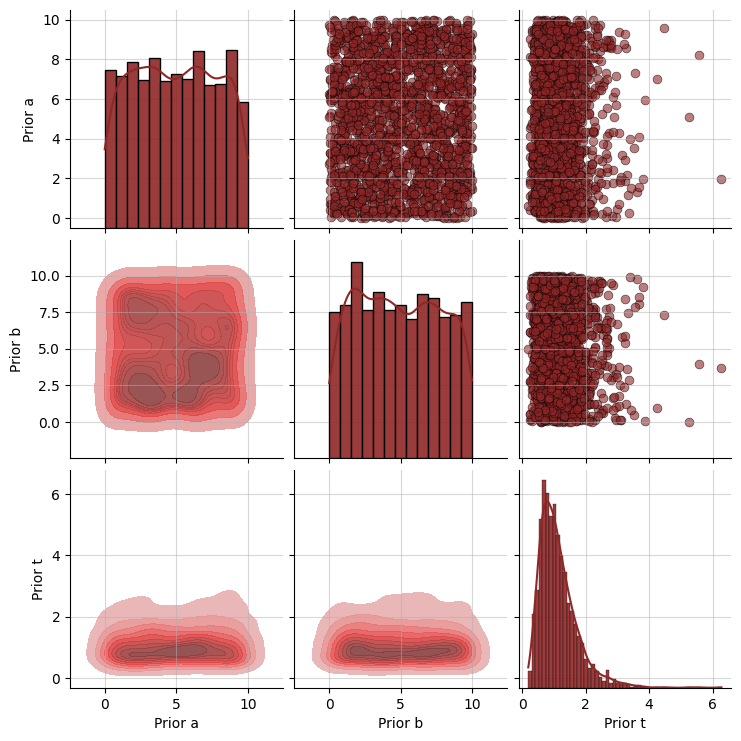

In [9]:
# As per default, the plot_prior2d function will obtain 1000 draws from the joint prior.
f = prior.plot_prior2d()

In [10]:
summary_net = SequenceNetwork()

In [11]:
inference_net = InvertibleNetwork(num_params=len(prior.param_names), num_coupling_layers=4)

In [12]:
amortizer = AmortizedPosterior(inference_net, summary_net, name="slovotvir_amortizer")

In [13]:
def configure_input(forward_dict):
    """Function to configure the simulated quantities (i.e., simulator outputs)
    into a neural network-friendly (BayesFlow) format.
    """

    # Prepare placeholder dict
    out_dict = {}

    # Convert data to logscale
    logdata = np.log1p(forward_dict["sim_data"]).astype(np.float32)

    # Extract prior draws and z-standardize with previously computed means
    params = forward_dict["prior_draws"].astype(np.float32)
    params = (params - prior_means) / prior_stds

    # Add to keys
    out_dict["summary_conditions"] = logdata
    out_dict["parameters"] = params

    out_dict["summary_conditions"] = np.expand_dims(out_dict["summary_conditions"], axis=2)

    return out_dict

In [14]:
x = configure_input(model(1))

In [15]:
x['summary_conditions'].shape

(1, 1000, 1)

In [16]:
trainer = Trainer(amortizer=amortizer, generative_model=model, configurator=configure_input, memory=True)

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [17]:
amortizer.summary()

Model: "slovotvir_amortizer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 invertible_network (Invert  multiple                  292936    
 ibleNetwork)                                                    
                                                                 
 sequence_network (Sequence  multiple                  91178     
 Network)                                                        
                                                                 
Total params: 384114 (1.47 MB)
Trainable params: 384090 (1.47 MB)
Non-trainable params: 24 (96.00 Byte)
_________________________________________________________________


In [18]:
%%time
gen_data = model(1000)

CPU times: user 53min 33s, sys: 11.3 s, total: 53min 45s
Wall time: 56min 36s


In [19]:
# pickle _
pickle.dump(gen_data, open('data_1000.pickle', 'wb'))
# unpickled = pickle.load(open('data.pickle', 'rb'))

In [47]:
%%time
history = trainer.train_offline(gen_data, epochs=50, batch_size=32, validation_sims=100)

INFO:root:Generated 100 simulations for validation.


Training epoch 1:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1, Loss: 4.026


Training epoch 2:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 2, Loss: 3.991


Training epoch 3:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 3, Loss: 3.880


Training epoch 4:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 4, Loss: 3.896


Training epoch 5:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 5, Loss: 3.872


Training epoch 6:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 6, Loss: 3.867


Training epoch 7:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 7, Loss: 3.974


Training epoch 8:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 8, Loss: 3.904


Training epoch 9:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 9, Loss: 3.920


Training epoch 10:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 10, Loss: 3.929


Training epoch 11:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 11, Loss: 3.988


Training epoch 12:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 12, Loss: 3.671


Training epoch 13:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 13, Loss: 3.418


Training epoch 14:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 14, Loss: 3.562


Training epoch 15:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 15, Loss: 3.648


Training epoch 16:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 16, Loss: 3.590


Training epoch 17:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 17, Loss: 3.524


Training epoch 18:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 18, Loss: 3.575


Training epoch 19:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 19, Loss: 3.423


Training epoch 20:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 20, Loss: 3.665


Training epoch 21:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 21, Loss: 3.459


Training epoch 22:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 22, Loss: 3.545


Training epoch 23:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 23, Loss: 3.488


Training epoch 24:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 24, Loss: 3.488


Training epoch 25:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 25, Loss: 3.481


Training epoch 26:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 26, Loss: 3.527


Training epoch 27:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 27, Loss: 3.483


Training epoch 28:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 28, Loss: 3.653


Training epoch 29:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 29, Loss: 3.817


Training epoch 30:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 30, Loss: 4.666


Training epoch 31:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 31, Loss: 3.782


Training epoch 32:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 32, Loss: 3.775


Training epoch 33:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 33, Loss: 3.805


Training epoch 34:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 34, Loss: 3.805


Training epoch 35:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 35, Loss: 3.658


Training epoch 36:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 36, Loss: 3.629


Training epoch 37:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 37, Loss: 3.637


Training epoch 38:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 38, Loss: 3.725


Training epoch 39:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 39, Loss: 3.713


Training epoch 40:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 40, Loss: 3.601


Training epoch 41:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 41, Loss: 3.651


Training epoch 42:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 42, Loss: 3.590


Training epoch 43:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 43, Loss: 3.631


Training epoch 44:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 44, Loss: 3.670


Training epoch 45:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 45, Loss: 3.686


Training epoch 46:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 46, Loss: 3.693


Training epoch 47:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 47, Loss: 3.695


Training epoch 48:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 48, Loss: 3.693


Training epoch 49:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 49, Loss: 3.692


Training epoch 50:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 50, Loss: 3.692


CPU times: user 22min 47s, sys: 9min 21s, total: 32min 8s
Wall time: 26min 23s


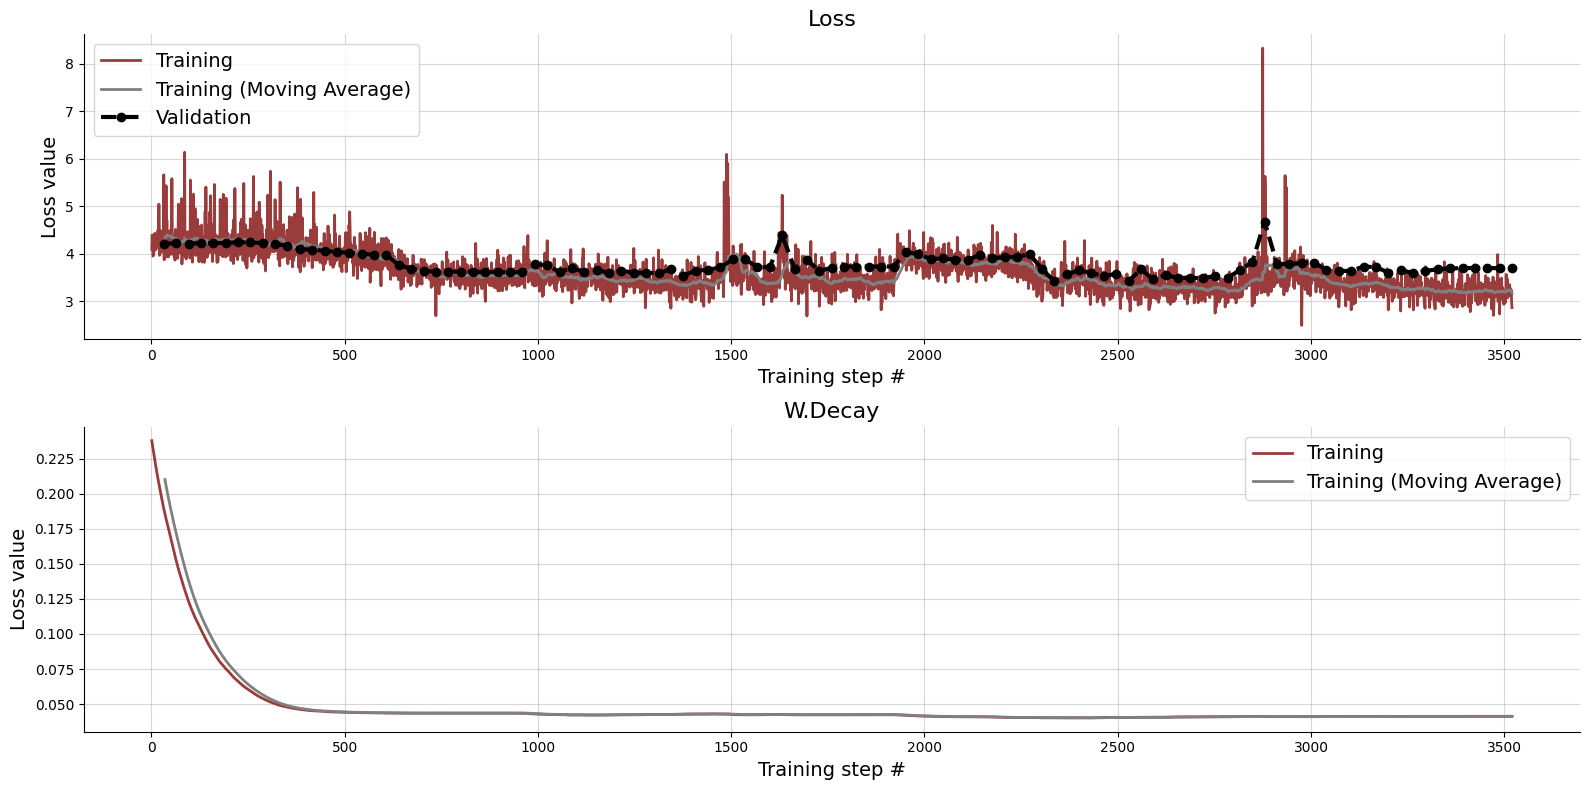

In [48]:
f = diag.plot_losses(history["train_losses"], history["val_losses"], moving_average=True)

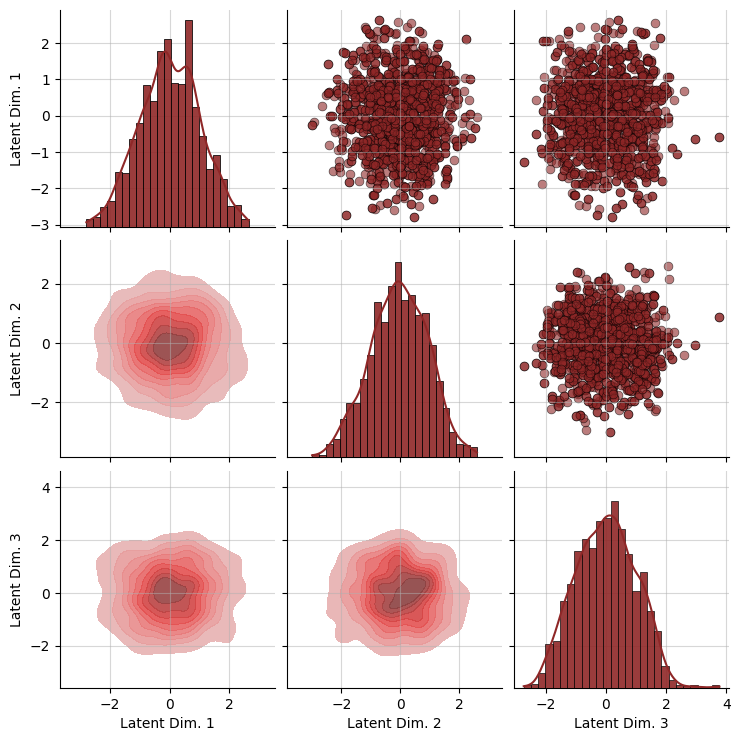

In [49]:
f = trainer.diagnose_latent2d()

INFO:root:The ratio of simulations / posterior draws should be > 20 for reliable variance reduction, but your ratio is 19.                    Confidence intervals might be unreliable!


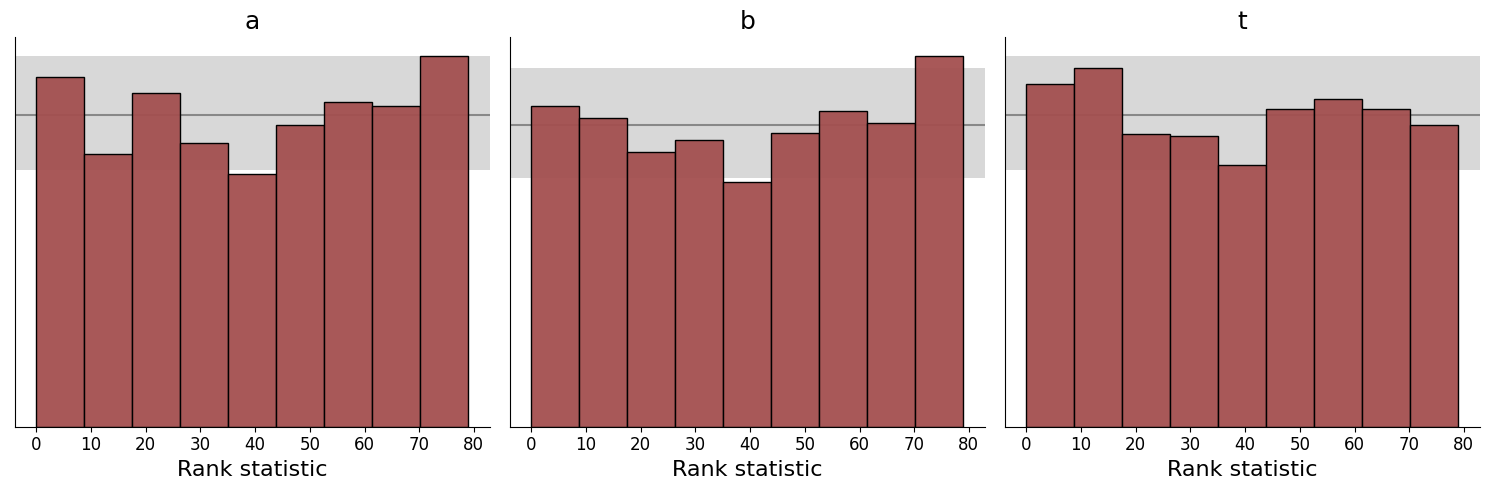

In [50]:
f = trainer.diagnose_sbc_histograms()

In [60]:
# Generate some validation data
validation_sims = trainer.configurator(model(batch_size=100))

In [63]:
# Generate posterior draws for all simulations
post_samples = amortizer.sample(validation_sims, n_samples=1000)

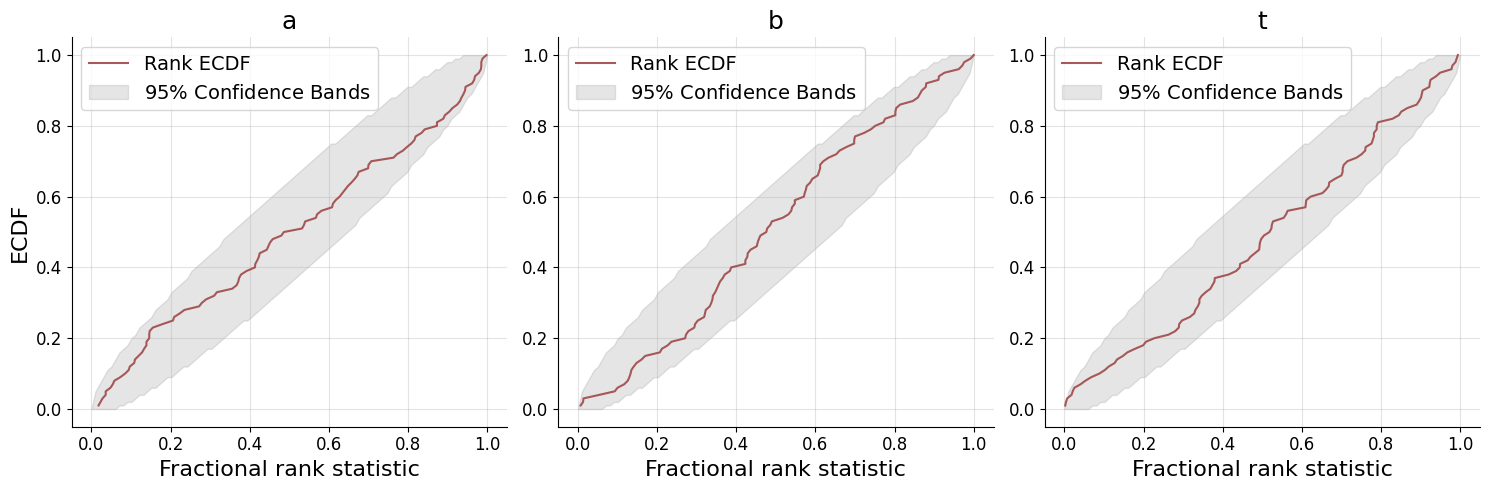

In [64]:
# Create ECDF plot
f = diag.plot_sbc_ecdf(post_samples, validation_sims["parameters"], param_names=prior.param_names)

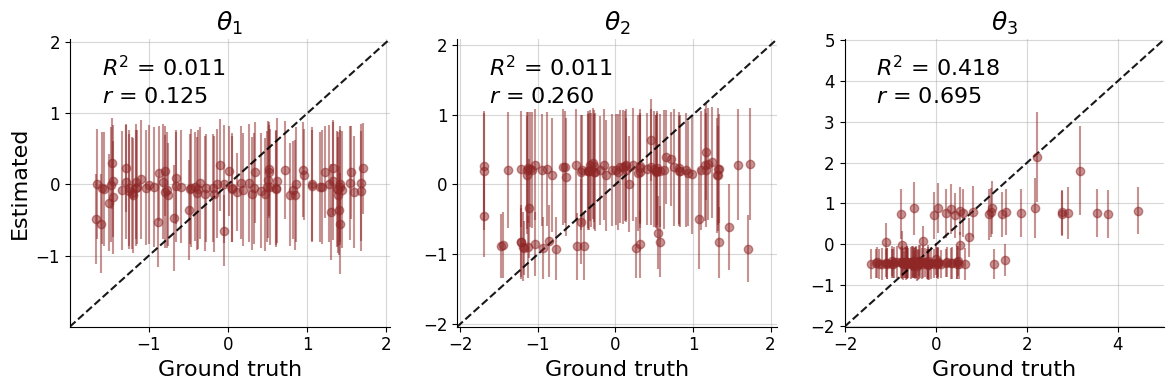

In [65]:
fig = diag.plot_recovery(post_samples, validation_sims["parameters"])

### 1. Posterior estimation:

In [51]:
with open('../data/true_likes.pkl', 'rb') as f:
    true_likes = pickle.load(f)

In [52]:
# Format data into a 3D array of shape (1, n_time_steps, 1) and perform log transform
obs_data = np.log1p(np.histogram(true_likes, bins=1000)[0])[np.newaxis, :, np.newaxis].astype(np.float32)
# obs_data = np.log1p(true_likes)[0])[np.newaxis, :, np.newaxis].astype(np.float32)

In [53]:
# Obtain 500 posterior draws given real data
post_samples = amortizer.sample({"summary_conditions": obs_data}, 1000)

# Undo standardization to get parameters on their original (unstandardized) scales
post_samples = prior_means + post_samples * prior_stds

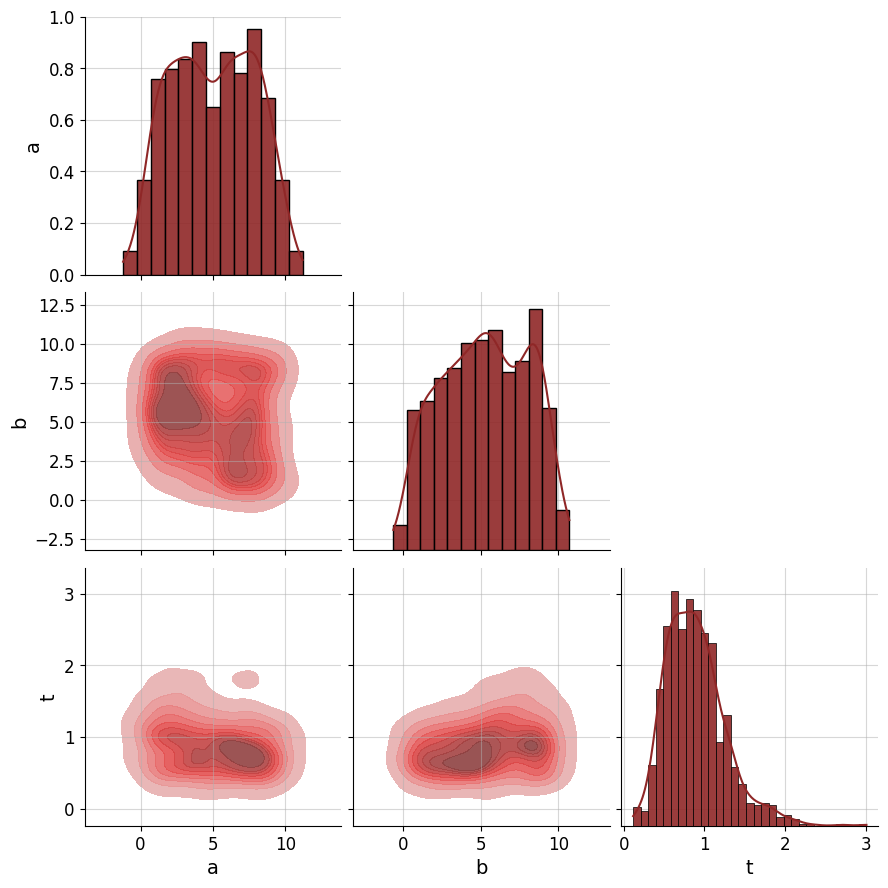

In [54]:
f = diag.plot_posterior_2d(post_samples, param_names=prior.param_names)

In [55]:
# # Generate some validation data
# validation_sims = trainer.configurator(model(batch_size=10))

# # Generate posterior draws for all simulations
# post_samples = amortizer.sample(validation_sims, n_samples=100)

In [56]:
# f = diag.plot_recovery(post_samples, validation_sims["parameters"], param_names=prior.param_names)

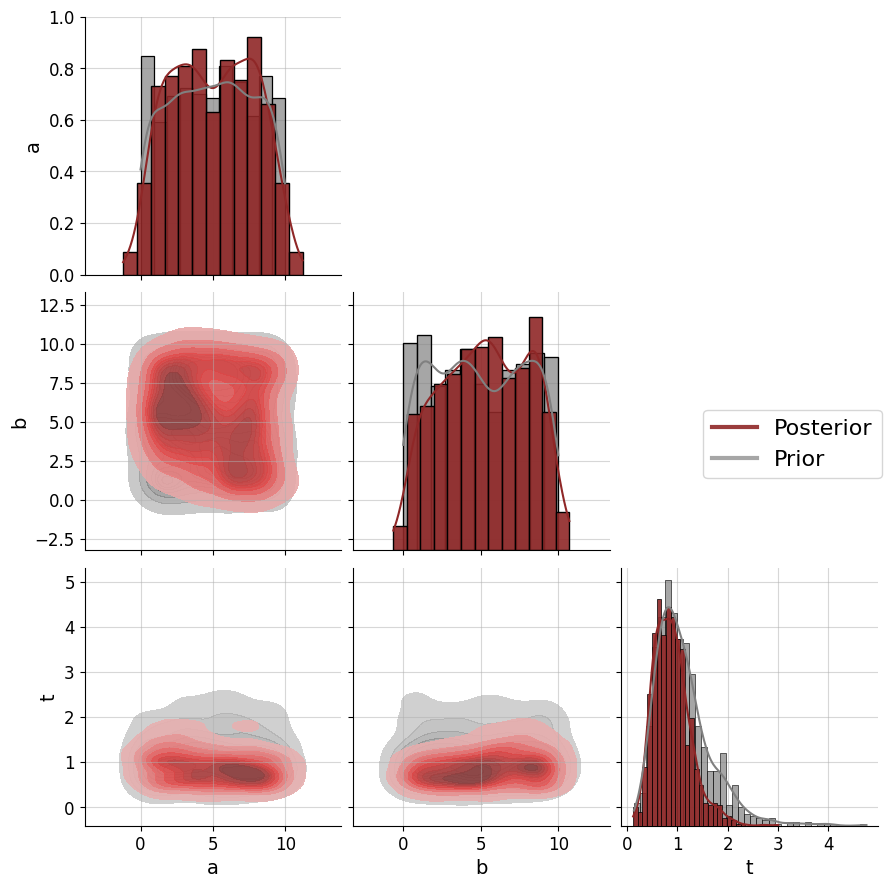

In [57]:
f = diag.plot_posterior_2d(post_samples, prior=prior)

In [58]:
post_samples.mean(axis=0)

array([5.01181722, 5.26772809, 0.89035386])

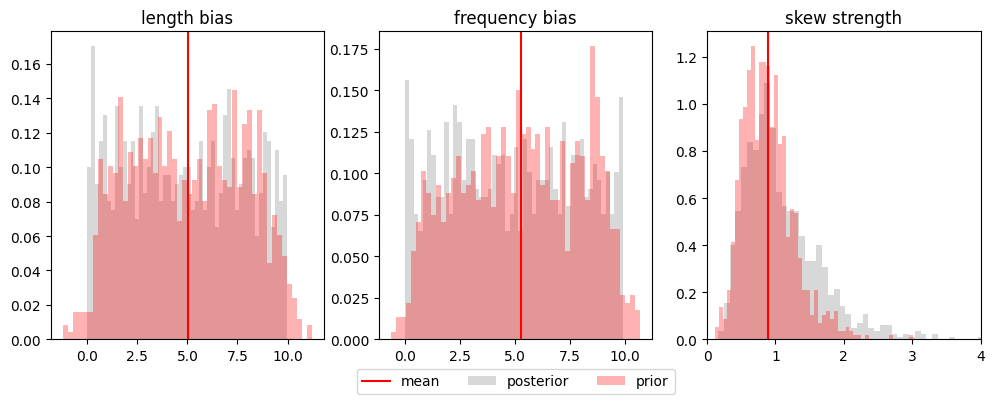

In [59]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].hist(np.random.uniform(0, 10, 1000), bins=50, alpha=0.3, color='grey', density=True)
axs[1].hist(np.random.uniform(0, 10, 1000), bins=50, alpha=0.3, color='grey', density=True)
axs[2].hist(np.random.lognormal(0, sigma=0.5, size=1000), bins=50, alpha=0.3, color='grey', density=True)

# Plot posteriors
axs[0].hist(post_samples[:, 0], bins=50, alpha=0.3, color='red', density=True)
axs[1].hist(post_samples[:, 1], bins=50, alpha=0.3, color='red', density=True)
axs[2].hist(post_samples[:, 2], bins=50, alpha=0.3, color='red', density=True)

# plot posterior means
axs[0].axvline(post_samples[:, 0].mean(), color='red')
axs[1].axvline(post_samples[:, 1].mean(), color='red')
axs[2].axvline(post_samples[:, 2].mean(), color='red')

# Set xlim for [2] to 0, 4
axs[2].set_xlim(0, 4)

# Set titles
axs[0].set_title('length bias')
axs[1].set_title('frequency bias')
axs[2].set_title('skew strength')

# Add legend below the subplots
plt.legend(['mean', 'posterior', 'prior'], bbox_to_anchor=(-0.7, -0.2), loc='lower center', ncol=3)

# Show the plot
plt.show()